In [ ]:
import numpy as np
import random
import time
import sklearn
import sklearn.metrics
import matplotlib
import matplotlib.pyplot as plt
from sklearn import cross_validation as cv
import sklearn.preprocessing
%matplotlib inline
tol = 10**(-10)

In [2]:
def kernel_expo(x,y,gamma):
    return np.exp(-gamma*(np.linalg.norm(x-y)**2))

In [3]:
def KKTviol(O,rho,mu,l,alpha,ens):
    ens2 = np.where(np.logical_or((rho-O[ens])*(1/(mu*l)-alpha[ens])>tol, (O[ens]-rho)*alpha[ens]>tol))
    if len(ens2[0]) == 0:
        return -1
    else :
        index = np.random.randint(len(ens2[0]))
        return ens[ens2[0][index]]

In [4]:
def argmax(O,i,ens):
    index = 0
    value = 0
    ens = list(ens)
    Oens = O[ens]
    return ens[np.argmax(O[i]-Oens)]

In [5]:
def optim(alpha,i,j,K,O,mu,l):
    delta = alpha[i]+alpha[j]
    Ci = O[i] - alpha[i]*K[i,i] -alpha[j]*K[i,j]
    Cj = O[j] - alpha[i]*K[i,j] -alpha[j]*K[j,j]
    # Condition droite (inutile dans le cas du noyau gaussien)
    if K[i,i]+K[j,j]-2*K[i,j] == 0:
        if Cj-Ci-K[i,i]>0:
            alphaj = max(0,delta-1/(l*mu))
            alphai = delta - alphaj
        elif Cj-Ci-K[i,i] <0:
            alphaj = min(1/(l*mu),delta)
            alphai = delta - alphaj
        else :
            alphaj = alpha[j]
            alphai = alpha[i]
    else:
        xmin =  (delta*(K[i,i]-K[i,j])+Ci-Cj)/( K[i,i]+K[j,j]-2*K[i,j])
        
        # condition si le min n'est pas atteint dans 0 1/(l*mu)
        # condition sur K inutile si noyau gaussien
        if K[i,i]+K[j,j]-2*K[i,j] < 0 or xmin <max(0,delta-1/(mu*l)) or xmin > min(1/(mu*l),delta):
            x0 = max(0,delta-1/(l*mu))
            fx0  = 1/2*(delta-x0)**2*K[i,i] + (delta-x0)*K[i,j] + 1/2*x0**2*K[j,j] + (delta-x0)*Ci + x0*Cj
            xmu = min(1/(l*mu),delta)
            fxmu  = 1/2*(delta-xmu)**2*K[i,i] + (delta-xmu)*K[i,j] + 1/2*xmu**2*K[j,j] + (delta-xmu)*Ci + xmu*Cj
            if fx0 > fxmu:
                alphaj = xmu
                alphai = delta - alphaj
            else :
                alphaj = x0
                alphai = delta - alphaj
        else :
            alphaj = xmin
            alphai = delta - alphaj

    alphai = delta - alphaj
    
    if alpha[i]+alpha[j] - (alphai + alphaj)>10**(-8):
        print("delta : ",alpha[i]+alpha[j], alphai + alphaj)
        print(alpha[i],alpha[j],alphai,alphaj)
    if alphai<0 or alphaj <0 or alphai >1/(mu*l) or alphaj >1/(mu*l):
        print("oups",alphai,alphaj)
    return alphai,alphaj
    

In [6]:
def SVcalc(alpha,c=1):
    SV = list(np.where(((alpha>tol) & (alpha<(c-tol))))[0])
    return SV

In [7]:
class osvm:
    def __init__(self,mu=0.01,maxiter=1000,maxiterii = 100,eps=0.001,gamma=5):
        assert mu>0,"mu doit être strictement positif"
        assert mu<=1,"mu doit être inférieur à 1"
        self.mu = mu
        self.eps = eps
        self.maxiter = maxiter
        self.maxiterii = maxiterii
        self.gamma = gamma
        self.len_sv = []
        self.rho_hist = []
        self.kkt_hist = []
        
    def fit(self,data):
        print("Initialisation")
        self.alpha = np.zeros(np.shape(data)[0])
        self.l = np.shape(data)[0] 
        l = self.l
        self.data = data
        K = np.array([[kernel_expo(x,y,self.gamma) for x in data] for y in data])
        choose = [i for i in range(l)]
        self.rho = 0
        s = 0
        while s <= 1-1/(l*self.mu):
            index = np.random.randint(len(choose))
            elem = choose[index]
            choose.remove(elem)
            self.alpha[elem] = 1/(l*self.mu)
            s += 1/(l*self.mu)
        if s != 1:
            index = np.random.randint(len(choose))
            elem = choose[index]
            choose.remove(elem)
            self.alpha[elem] = 1-s
            s = 1

        O = np.dot(self.alpha,K)
        self.rho = max(O[self.alpha>tol])
        self.rho_hist.append(self.rho)

        print("Apprentissage")
        iter_etape = 0
        iteration = 0
        while iteration < self.maxiter:
            # Etape (i)
            enskkt = list(range(l))
            np.random.shuffle(enskkt)
            index = KKTviol(O,self.rho,self.mu,l,self.alpha,enskkt)
            iteration += 1
            if index == -1:
                print(iteration,"break index")
                break

            if iteration == 1 :
                SV = SVcalc(self.alpha)
            else:
                SV = SVcalc(self.alpha,1/(self.mu*l))
            
            while index in SV:
                    SV.remove(index)
            if SV == []:
                SV = SVcalc(self.alpha)
                while index in SV:
                    SV.remove(index)
            if SV ==[]:
                continue
            
            j = argmax(O,index,SV)
            alpha_index,alpha_j = self.alpha[index],self.alpha[j]
            self.alpha[index],self.alpha[j] = optim(self.alpha,index,j,K,O,self.mu,l)
            if sum(self.alpha) > 1.001:
                print("etape i " ,sum(self.alpha))
                time.sleep(0.5)
            
            # update de rho
            O += K[index,:]*(self.alpha[index]-alpha_index) + K[j,:]*(self.alpha[j]-alpha_j)
            O_actif = O[ ((self.alpha>tol) & (self.alpha< (1/(l*self.mu)-tol)))]
            if len(O_actif)==0:
                self.rho = max(O[ (self.alpha>tol )]) 
            else:
                self.rho = np.mean(O_actif)

            self.rho_hist.append(self.rho)
            SV = SVcalc(self.alpha,1/(self.mu*l))
            
            # Etape (ii)
            np.random.shuffle(SV)
            index = KKTviol(O,self.rho,self.mu,l,self.alpha,SV)
            self.kkt_hist.append(len(np.where((self.rho-O[SV])*(1/(self.mu*l)-self.alpha[SV])>tol)[0])+ 
                                                            len(np.where((O[SV]-self.rho)*self.alpha[SV]>tol)[0]))
            iterii = 0
            while index !=-1 and len(SV)>=1 and iterii < self.maxiterii:
                iterii += 1
                while index in SV:
                    SV.remove(index)
                    
                if SV != []:
                    iter_etape += 1
                    j = argmax(O,index,SV)
                    Osv = O[index] - O
                    delta = self.alpha[index] + self.alpha[j]
                    alpha_index,alpha_j = self.alpha[index],self.alpha[j]
                    self.alpha[index] , self.alpha[j] = optim(self.alpha,index,j,K,O,self.mu,l)

                    O += K[index,:]*(self.alpha[index]-alpha_index) + K[j,:]*(self.alpha[j]-alpha_j)
                    O_actif = O[ ((self.alpha>tol) & (self.alpha< (1/(l*self.mu)-tol)))]
                    if len(O_actif) == 0:
                        self.rho = max(O[ (self.alpha>tol )]) 
                    else:
                        self.rho = np.mean(O_actif)
                    self.rho_hist.append(self.rho)
                    self.O = O
                    self.K = K
                    SV = SVcalc(self.alpha,1/(self.mu*l))
                else:
                    continue
                    
                
                if len(SV) == 1:
                    print("len sv break")
                    break
                np.random.shuffle(SV)   
                index = KKTviol(O,self.rho,self.mu,l,self.alpha,SV)
                self.kkt_hist.append(len(np.where((self.rho-O[SV])*(1/(self.mu*l)-self.alpha[SV])>tol)[0])+ 
                                                            len(np.where((O[SV]-self.rho)*self.alpha[SV]>tol)[0]))
                if index == -1:
                    break
                while index in SV:
                    SV.remove(index)
                
            if iteration%100 == 0 :
                print(iter_etape,iteration,self.maxiter,self.rho,np.dot(self.alpha,np.dot(self.alpha,K)))
                iter_etape = 0 
            
        # update rho
        O_actif = O[ ((self.alpha>tol) & (self.alpha< (1/(l*self.mu)-tol)))]
        if len(O_actif) == 0:
            print("rho out")
            self.rho = max(O[ (self.alpha>tol )]) 
        else:
            self.rho = np.mean(O_actif)
    
    def predict(self,xi):
        K = np.array([[kernel_expo(x,xie,self.gamma) for xie in xi ]for x in self.data])
        return np.sign(np.dot(self.alpha,K)-self.rho)
    
    def decision_function(self,xi):
        K = np.array([[kernel_expo(x,xie,self.gamma) for xie in xi ]for x in self.data])
        return np.dot(self.alpha,K)-self.rho

# Apprentissage sur uniforme [-1;1]

In [8]:
data = 2*(-0.5 + np.random.rand(500))

In [9]:
test = osvm(mu=10**(-10),gamma = 1,maxiter=1000,maxiterii=50)
test.fit(data)

Initialisation
Apprentissage
4461 100 1000 0.484334711584 0.484334711522
5000 200 1000 0.484334711584 0.484334711522
5000 300 1000 0.484334711584 0.484334711522
5000 400 1000 0.484334711584 0.484334711522
5000 500 1000 0.484334711584 0.484334711522
5000 600 1000 0.484334711584 0.484334711522
5000 700 1000 0.484334711584 0.484334711522
5000 800 1000 0.484334711584 0.484334711522
5000 900 1000 0.484334711584 0.484334711522
5000 1000 1000 0.484334711584 0.484334711522


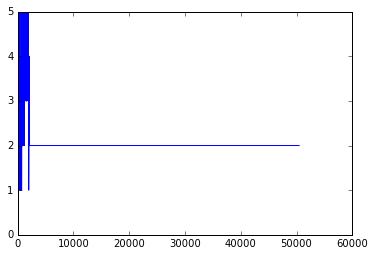

In [10]:
plt.plot(test.kkt_hist)

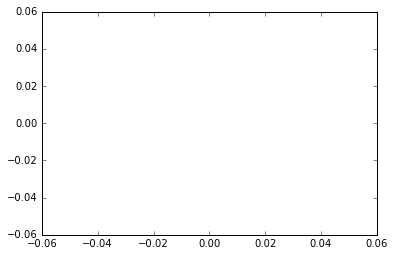

In [11]:
plt.plot(test.len_sv)
#plt.plot(test.lenOsv,'r')
plt.show()

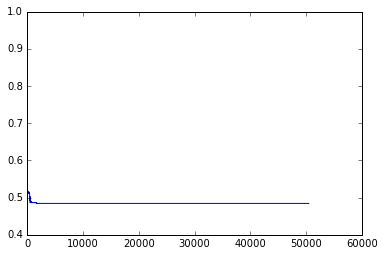

In [12]:
plt.plot(test.rho_hist)

In [13]:
test.alpha[test.alpha>0]

array([ 0.18073172,  0.40974696,  0.40952132])

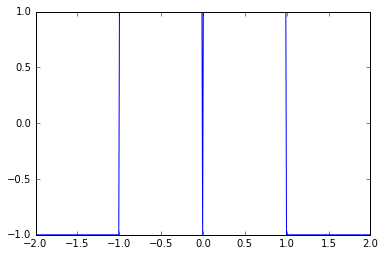

In [14]:
x=np.linspace(-2,2,500)
y = test.predict(x)
plt.plot(x,y)

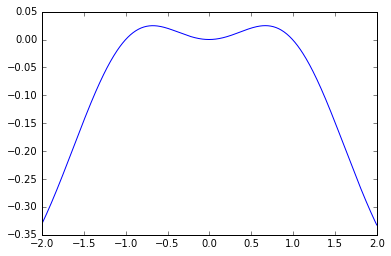

In [15]:
y = test.decision_function(x)
plt.plot(x,y)

In [16]:
xtest=np.linspace(-1,1,1000)

In [21]:
nb = sum(0.5*(1+test.predict(xtest)))
nbdata = sum(0.5*(1+test.predict(data)))
print(nb,nbdata)

993.0 498.0


# Apprentissage sur  uniforme $[-2,-1.7]^2 \cup [2,2.3]^2$

In [24]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = osvm(mu=0.022,gamma = 0.1,maxiter=1000,maxiterii=100)
clf.fit(X_train)


Initialisation
Apprentissage
8661 100 1000 0.451764510873 0.449333348396
10000 200 1000 0.451764510873 0.449333348396
10000 300 1000 0.451764510873 0.449333348396
10000 400 1000 0.451764510873 0.449333348396
10000 500 1000 0.451764510873 0.449333348396
10000 600 1000 0.451764510873 0.449333348396
10000 700 1000 0.451764510873 0.449333348396
10000 800 1000 0.451764510873 0.449333348396
10000 900 1000 0.451764510873 0.449333348396
10000 1000 1000 0.451764510873 0.449333348396


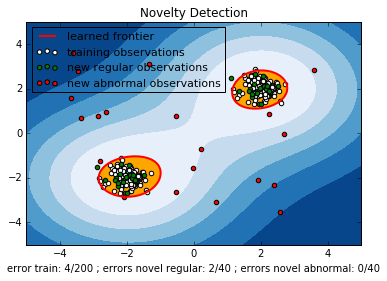

In [25]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

# Test sur les données USPS

In [8]:
def load_usps(filename):
    with open(filename ,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)
datax,y = load_usps("usps.txt")
#plt.imshow(datax[1].reshape((16,16)),interpolation="nearest")

data_entier = [[] for i in range(10)]
for entier in range(10):
    data_entier[entier] = datax[ y == entier]

In [66]:
usps_osvm = osvm(mu=0.2,gamma = 1/(0.5*256),maxiter=3000,maxiterii=300)

In [67]:
data_train_6,data_test_6=cv.train_test_split(data_entier[6],test_size=0.3)
usps_osvm.fit(data_train_6)

Initialisation
Apprentissage
len sv break
len sv break
len sv break
len sv break
len sv break
37 100 3000 0.336454843553 0.280458740381
len sv break
len sv break
2 200 3000 0.219062500474 0.25872852403
len sv break
len sv break
len sv break
2755 300 3000 0.323917488401 0.253041176362
len sv break
len sv break
len sv break
13563 400 3000 0.260282961516 0.245359146177
len sv break
11216 500 3000 0.298675858214 0.24231913043
len sv break
len sv break
len sv break
len sv break
len sv break
3059 600 3000 0.290987543231 0.235901377801
1026 700 3000 0.289257932251 0.235832316614
11132 800 3000 0.279387620927 0.233382913156
23323 900 3000 0.281028180128 0.232690410757
16934 1000 3000 0.280253783553 0.232416778199
len sv break
14427 1100 3000 0.277123749207 0.231688486207
20699 1200 3000 0.274237941114 0.231188034194
20785 1300 3000 0.268260177215 0.229939718141
9390 1400 3000 0.268498913123 0.229163805346
28400 1500 3000 0.266040735033 0.22868492052
25800 1600 3000 0.264404644001 0.22832325638

In [68]:
is_6_a_6_test = sum(0.5*(1+usps_osvm.predict(data_test_6)))
print("Prediction sur l'ensemble test : ",is_6_a_6_test/len(data_test_6))

Prediction sur l'ensemble test :  0.54


In [69]:
is_9_a_6 = sum(0.5*(1+usps_osvm.predict(data_entier[9])))
is_6_a_6 = sum(0.5*(1+usps_osvm.predict(data_entier[6])))
print(is_9_a_6,is_6_a_6/len(data_entier[6]))

0.0 0.536144578313


##Plus précis ?

In [59]:
usps_osvm_precis = osvm(mu=0.000002,gamma = 1/(0.5*256),maxiter=1000,maxiterii=100)

In [60]:
usps_osvm_precis.fit(data_train_6)

Initialisation
Apprentissage
9800 100 1000 0.186744699465 0.186751282949
10000 200 1000 0.169090700908 0.169075600309
10000 300 1000 0.168149699463 0.168149641203
10000 400 1000 0.166282466314 0.166282665741
10000 500 1000 0.166036140962 0.16603613615
10000 600 1000 0.166022389032 0.16602237262
10000 700 1000 0.159980558679 0.159958416154
10000 800 1000 0.159835234274 0.159835234029
10000 900 1000 0.159817379898 0.159817372762
10000 1000 1000 0.159817386555 0.159817361865


In [22]:
is_6_a_6_test_precis = sum(0.5*(1+usps_osvm.predict(data_test_6)))
print("Prediction sur l'ensemble test:",is_6_a_6_test_precis/len(data_test_6))

is_9_a_6_precis = sum(0.5*(1+usps_osvm_precis.predict(data_entier[9])))
is_6_a_6_precis = sum(0.5*(1+usps_osvm_precis.predict(data_entier[6])))
print("Prediction sur la classe 9",is_9_a_6_precis, "Prediction sur l'ensemble de la classe 6",is_6_a_6_precis/len(data_entier[6]))

Prediction sur l'ensemble test: 0.82
Prediction sur la classe 9 0.0 Prediction sur l'ensemble de la classe 6 0.871987951807


## Test sur les troubles du rythme cardiaque

In [40]:
def load_cardiac(filename):
    with open(filename ,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f]
    tmp = np.array(data)
    return tmp[:,:-1],tmp[:,-1].astype(int)

data_card,y_card = load_cardiac("card_clean.txt")
data_card = sklearn.preprocessing.scale(data_card,axis=0)

In [41]:
data_card_ok = data_card[y_card == 1]
data_card_dead = data_card[y_card != 1]

In [42]:
data_card_train,data_card_test=cv.train_test_split(data_card_ok,test_size=0.2)

In [ ]:
card_osvm = osvm(mu=0.03,gamma = 0.95*10**(-2),maxiter=1000,maxiterii=100)

In [ ]:
card_osvm.fit(data_card_train)

In [ ]:
print("Test données entrainement : ", sum(0.5*(1+card_osvm.predict(data_card_train)))/len(data_card_train))
print("Test données validation : ", sum(0.5*(1+card_osvm.predict(data_card_test)))/len(data_card_test))
print("Test données ok: ", sum(0.5*(1+card_osvm.predict(data_card_ok)))/len(data_card_ok))
print("Test données dead: ", sum(0.5*(1+card_osvm.predict(data_card_dead)))/len(data_card_dead))

#Yahoo
http://webscope.sandbox.yahoo.com/catalog.php?datatype=s&did=70

In [160]:
card_osvm.alpha

array([ 0.02326715,  0.        ,  0.        ,  0.02009537,  0.00625608,
        0.00828821,  0.0073981 ,  0.01432296,  0.        ,  0.01558495,
        0.0110989 ,  0.00745983,  0.00130038,  0.        ,  0.00488351,
        0.        ,  0.        ,  0.        ,  0.        ,  0.00027705,
        0.00203914,  0.        ,  0.        ,  0.        ,  0.        ,
        0.01635565,  0.01529841,  0.00440153,  0.01150863,  0.01187373,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00485726,  0.        ,  0.        ,  0.01971075,  0.        ,
        0.0016465 ,  0.        ,  0.        ,  0.        ,  0.00186744,
        0.014914  ,  0.        ,  0.        ,  0.01177404,  0.        ,
        0.02197333,  0.        ,  0.01835562,  0.        ,  0.        ,
        0.01026658,  0.        ,  0.        ,  0.01067953,  0.0037196 ,
        0.00983698,  0.        ,  0.        ,  0.        ,  0.        ,
        0.01003382,  0.00851804,  0.01421792,  0.00142653,  0.00

# Hack

In [16]:
def load_hack(filename):
    with open(filename ,"r") as f:
        len_f = len(list(f))
        f.seek(0)
        len_line = len(f.readline().split(','))
        data = np.array([[0 for x in range(len_line)] for i in range(len_f)])
        dict_convert = [[] for i in range(len_line)]
        f.seek(0)
        for line in range(len_f):
            freadline = f.readline()
            spl = freadline .split(',')
            for elem in range(len_line):
                try:
                    data[line,elem] = float(spl[elem])
                except:
                    if spl[elem] in dict_convert[elem]:
                        getnb = dict_convert[elem].index(spl[elem])
                    else:
                        dict_convert[elem].append(spl[elem])
                        getnb = dict_convert[elem].index(spl[elem])
                    data[line,elem] = float(getnb)

    tmp = np.array(data)
    return tmp[:,:-1],tmp[:,-1].astype(int)

data_hack,y_hack = load_hack('hack')

In [22]:
data_hack_nm = sklearn.preprocessing.scale(data_hack,axis=0)

C:\Users\User\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [74]:
data_hack_ras = data_hack_nm[y_hack == 1][:5000]
data_hack_wip = data_hack_nm[y_hack != 1][:5000]
data_hack_train,data_hack_test=cv.train_test_split(data_hack_ras,test_size=0.7)

In [75]:
hack_osvm = osvm(mu=0.2,gamma = 1/(0.5*256),maxiter=1000,maxiterii=100)

In [ ]:
hack_osvm.fit(data_hack_train)

In [ ]:
print("Test données entrainement : ", sum(0.5*(1+hack_osvm.predict(data_hack_train)))/len(data_hack_train))
print("Test données validation : ", sum(0.5*(1+hack_osvm.predict(data_hack_test)))/len(data_hack_test))
print("Test données ok: ", sum(0.5*(1+hack_osvm.predict(data_hack_ras)))/len(data_hack_ras))
print("Test données dead: ", sum(0.5*(1+hack_osvm.predict(data_hack_wip)))/len(data_hack_wip))

In [ ]:
utilisation : 
    antivirus, hack, médecine